# Assignment 2: Naive Bayes
Welcome to week two of this specialization. You will learn about Naive Bayes. Concretely, you will be using Naive Bayes for sentiment analysis on tweets. Given a tweet, you will decide if it has a positive sentiment or a negative one. Specifically you will: 

* Train a naive bayes model on a sentiment analysis task
* Test using your model
* Compute ratios of positive words to negative words
* Do some error analysis
* Predict on your own tweet

You may already be familiar with Naive Bayes and its justification in terms of conditional probabilities and independence.
* In this week's lectures and assignments we used the ratio of probabilities between positive and negative sentiments.
* This approach gives us simpler formulas for these 2-way classification tasks.

Load the cell below to import some packages.
You  may want to browse the documentation of unfamiliar libraries and functions.

In [1]:
import pdb
import nltk
from nltk.corpus import twitter_samples
import numpy as np
import pandas as pd
import string
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

%matplotlib inline
%config InlineBackend.figure_format='svg'

In [2]:
all_positive_tweets=twitter_samples.strings('positive_tweets.json')
all_negative_tweets=twitter_samples.strings('negative_tweets.json')

# Split the data
train_pos=all_positive_tweets[:4000]
test_pos=all_positive_tweets[4000:]
train_neg=all_negative_tweets[:4000]
test_neg=all_negative_tweets[4000:]

train_x=train_pos+train_neg
test_x=test_pos+test_neg

train_y=np.append(np.ones(len(train_pos)),np.zeros(len(train_neg)))
test_y=np.append(np.ones(len(test_pos)),np.zeros(len(test_neg)))

In [4]:
train_x[0], train_y[0]

('#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
 1.0)

# Part 1: Process the Data

For any machine learning project, once you've gathered the data, the first step is to process it to make useful inputs to your model.
- **Remove noise**: You will first want to remove noise from your data -- that is, remove words that don't tell you much about the content. These include all common words like 'I, you, are, is, etc...' that would not give us enough information on the sentiment.
- We'll also remove stock market tickers, retweet symbols, hyperlinks, and hashtags because they can not tell you a lot of information on the sentiment.
- You also want to remove all the punctuation from a tweet. The reason for doing this is because we want to treat words with or without the punctuation as the same word, instead of treating "happy", "happy?", "happy!", "happy," and "happy." as different words.
- Finally you want to use stemming to only keep track of one variation of each word. In other words, we'll treat "motivation", "motivated", and "motivate" similarly by grouping them within the same stem of "motiv-".

We have given you the function `process_tweet()` that does this for you.

In [6]:
en_stopswords = stopwords.words("english")
en_stopswords, len(en_stopswords)

(['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out',
  'on',
  'off',
  'over',
  'under',
  'again',
  'further',
  'th

In [9]:
def process_tweet(tweet):
    stemmer=PorterStemmer()  # 去除英文词缀，只保留主干
    stopwords_english=stopwords.words('english')
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    tokenizer=TweetTokenizer(preserve_case=False,strip_handles=True,
                             reduce_len=True)
    
    tweet_tokens=tokenizer.tokenize(tweet)
    
    tweets_clean=[]
    
    for word in tweet_tokens:
        if (word not in stopwords_english  # remove stopwords
            and word not in string.punctuation):  # remove punctuation
            stem_word=stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)
            
    return tweets_clean

In [10]:
# Test
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"

# print cleaned tweet
print(process_tweet(custom_tweet))

['hello', 'great', 'day', ':)', 'good', 'morn']


## Part 1.1 Implementing your helper functions

To help train your naive bayes model, you will need to build a dictionary where the keys are a (word, label) tuple and the values are the corresponding frequency.  Note that the labels we'll use here are 1 for positive and 0 for negative.

You will also implement a `lookup()` helper function that takes in the `freqs` dictionary, a word, and a label (1 or 0) and returns the number of times that word and label tuple appears in the collection of tweets.

For example: given a list of tweets `["i am rather excited", "you are rather happy"]` and the label 1, the function will return a dictionary that contains the following key-value pairs:

{
    ("rather", 1): 2
    ("happi", 1) : 1
    ("excit", 1) : 1
}

- Notice how for each word in the given string, the same label 1 is assigned to each word.
- Notice how the words "i" and "am" are not saved, since it was removed by process_tweet because it is a stopword.
- Notice how the word "rather" appears twice in the list of tweets, and so its count value is 2.

#### Instructions
Create a function `count_tweets()` that takes a list of tweets as input, cleans all of them, and returns a dictionary.
- The key in the dictionary is a tuple containing the stemmed word and its class label, e.g. ("happi",1).
- The value the number of times this word appears in the given collection of tweets (an integer).

In [13]:
def count_tweets(tweets, ys):
    result = {}
    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            pair=(word, y)
            
            if pair in result:
                result[pair] += 1
            else:
                result[pair] = 1
                
    return result

In [14]:
# Test
tweets = ['i am happy', 'i am tricked', 'i am sad', 'i am tired', 'i am tired']
ys = [1, 0, 0, 0, 0]
count_tweets(tweets, ys)

{('happi', 1): 1, ('trick', 0): 1, ('sad', 0): 1, ('tire', 0): 2}

# Part 2: Train your model using Naive Bayes

Naive bayes is an algorithm that could be used for sentiment analysis. It takes a short time to train and also has a short prediction time.

#### So how do you train a Naive Bayes classifier?
- The first part of training a naive bayes classifier is to identify the number of classes that you have.
- You will create a probability for each class.
$P(D_{pos})$ is the probability that the document is positive.
$P(D_{neg})$ is the probability that the document is negative.
Use the formulas as follows and store the values in a dictionary:

$$P(D_{pos}) = \frac{D_{pos}}{D}\tag{1}$$

$$P(D_{neg}) = \frac{D_{neg}}{D}\tag{2}$$

Where $D$ is the total number of documents, or tweets in this case, $D_{pos}$ is the total number of positive tweets and $D_{neg}$ is the total number of negative tweets.

#### Prior and Logprior

The prior probability represents the underlying probability in the target population that a tweet is positive versus negative.  In other words, if we had no specific information and blindly picked a tweet out of the population set, what is the probability that it will be positive versus that it will be negative? That is the "prior".

The prior is the ratio of the probabilities $\frac{P(D_{pos})}{P(D_{neg})}$.
We can take the log of the prior to rescale it, and we'll call this the logprior

$$\text{logprior} = log \left( \frac{P(D_{pos})}{P(D_{neg})} \right) = log \left( \frac{D_{pos}}{D_{neg}} \right)$$.

Note that $log(\frac{A}{B})$ is the same as $log(A) - log(B)$.  So the logprior can also be calculated as the difference between two logs:

$$\text{logprior} = \log (P(D_{pos})) - \log (P(D_{neg})) = \log (D_{pos}) - \log (D_{neg})\tag{3}$$

#### Log likelihood
To compute the loglikelihood of that very same word, we can implement the following equations:

$$\text{loglikelihood} = \log \left(\frac{P(W_{pos})}{P(W_{neg})} \right)\tag{6}$$

##### Create `freqs` dictionary
- Given your `count_tweets()` function, you can compute a dictionary called `freqs` that contains all the frequencies.
- In this `freqs` dictionary, the key is the tuple (word, label)
- The value is the number of times it has appeared.

We will use this dictionary in several parts of this assignment.

In [17]:
freqs = count_tweets(train_x, train_y)
len(freqs)

11339

#### Instructions
Given a freqs dictionary, `train_x` (a list of tweets) and a `train_y` (a list of labels for each tweet), implement a naive bayes classifier.

##### Calculate $V$
- You can then compute the number of unique words that appear in the `freqs` dictionary to get your $V$ (you can use the `set` function).

##### Calculate $freq_{pos}$ and $freq_{neg}$
- Using your `freqs` dictionary, you can compute the positive and negative frequency of each word $freq_{pos}$ and $freq_{neg}$.

##### Calculate $N_{pos}$, $N_{neg}$, $V_{pos}$, and $V_{neg}$
- Using `freqs` dictionary, you can also compute the total number of positive words and total number of negative words $N_{pos}$ and $N_{neg}$.
- Similarly, use `freqs` dictionary to compute the total number of **unique** positive words, $V_{pos}$, and total **unique** negative words $V_{neg}$.

##### Calculate $D$, $D_{pos}$, $D_{neg}$
- Using the `train_y` input list of labels, calculate the number of documents (tweets) $D$, as well as the number of positive documents (tweets) $D_{pos}$ and number of negative documents (tweets) $D_{neg}$.
- Calculate the probability that a document (tweet) is positive $P(D_{pos})$, and the probability that a document (tweet) is negative $P(D_{neg})$

##### Calculate the logprior
- the logprior is $log(D_{pos}) - log(D_{neg})$

##### Calculate log likelihood
- Finally, you can iterate over each word in the vocabulary, use your `lookup` function to get the positive frequencies, $freq_{pos}$, and the negative frequencies, $freq_{neg}$, for that specific word.
- Compute the positive probability of each word $P(W_{pos})$, negative probability of each word $P(W_{neg})$ using equations 4 & 5.

$$ P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V}\tag{4} $$
$$ P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V}\tag{5} $$

**Note:** We'll use a dictionary to store the log likelihoods for each word.  The key is the word, the value is the log likelihood of that word).

- You can then compute the loglikelihood: $log \left( \frac{P(W_{pos})}{P(W_{neg})} \right)$.

In [18]:
def lookup(freqs, word, label):
    n=0
    pair=(word, label)
    
    if pair in freqs:
        n=freqs[pair]
    return n

In [22]:
def train_naive_bayes(freqs, train_x, train_y):
    loglikelihood = {}
    logprior = 0
    
    # Calculate V,the number of unique words in the vocab
    vocab=set([pair[0] for pair in freqs.keys()])
    V = len(vocab)
    
    # Calculate N_pos,N_neg,V_pos,V_neg
    N_pos = N_neg = 0  # 词汇出现次数总和
#     V_pos=V_neg=0
    
    for pair in freqs.keys():
        if pair[1]>0:
#             V_pos+=1
            N_pos += freqs[pair]
        else:
#             V_neg+=1
            N_neg += freqs[pair]
    
#     D=len(train_y)

    # Calculate D_pos,the number of positive documents
    D_pos = (len(list(filter(lambda x:x>0, train_y))))
         
    # Calculate D_neg,the number of negative documents
    D_neg = (len(list(filter(lambda x:x<=0, train_y))))
    print("pos num: {}, neg num: {}".format(D_pos, D_neg))

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)
    
    for word in vocab:
        # Calculate the frequency of positive/negative word
        freq_pos = lookup(freqs, word, 1)
        freq_neg = lookup(freqs, word, 0)
        
        # Calculate the probability that each word is positice/negative
        p_w_pos = (freq_pos+1)/(N_pos+V)
        p_w_neg = (freq_neg+1)/(N_neg+V)
         
        # Calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)
        
    return logprior,loglikelihood

In [23]:
logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))

pos num: 4000, neg num: 4000
0.0
9084


In [24]:
np.log(1/1)

0.0

# Part 3: Test your naive bayes

Now that we have the `logprior` and `loglikelihood`, we can test the naive bayes function by making predicting on some tweets!

#### Implement `naive_bayes_predict`
**Instructions**:
Implement the `naive_bayes_predict` function to make predictions on tweets.
* The function takes in the `tweet`, `logprior`, `loglikelihood`.
* It returns the probability that the tweet belongs to the positive or negative class.
* For each tweet, sum up loglikelihoods of each word in the tweet.
* Also add the logprior to this sum to get the predicted sentiment of that tweet.

$$ p = logprior + \sum_i^N (loglikelihood_i)$$

#### Note
Note we calculate the prior from the training data, and that the training data is evenly split between positive and negative labels (4000 positive and 4000 negative tweets).  This means that the ratio of positive to negative 1, and the logprior is 0.

The value of 0.0 means that when we add the logprior to the log likelihood, we're just adding zero to the log likelihood.  However, please remember to include the logprior, because whenever the data is not perfectly balanced, the logprior will be a non-zero value.

In [26]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    word_1 = process_tweet(tweet)
    p = 0
    p += logprior
    for word in word_1:
        if word in loglikelihood:
            p += loglikelihood[word]        
    return p

In [27]:
# Test
my_tweet = 'She smiled.'
p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1.5737795839220972


#### Implement test_naive_bayes
**Instructions**:
* Implement `test_naive_bayes` to check the accuracy of your predictions.
* The function takes in your `test_x`, `test_y`, log_prior, and loglikelihood
* It returns the accuracy of your model.
* First, use `naive_bayes_predict` function to make predictions for each tweet in text_x.

In [29]:
def test_naive_bayes(test_x,test_y,logprior,loglikelihood):
    accuracy=0
    y_hats=[]
    
    for tweet in test_x:
        if naive_bayes_predict(tweet,logprior,loglikelihood)>0:
            y_hat_i=1
        else:
            y_hat_i=0
        y_hats.append(y_hat_i)
    
    error=np.mean(np.absolute(y_hats-test_y))
    
    accuracy=1-error
    
    return accuracy

In [30]:
print("Naive Bayes accuracy = %0.4f" %
      (test_naive_bayes(test_x, test_y, logprior, loglikelihood)))

Naive Bayes accuracy = 0.9940


In [31]:
# Test
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    p = naive_bayes_predict(tweet, logprior, loglikelihood)
    print(f'{tweet} -> {p:.2f}')

I am happy -> 2.15
I am bad -> -1.29
this movie should have been great. -> 2.14
great -> 2.14
great great -> 4.28
great great great -> 6.41
great great great great -> 8.55


In [32]:
# Test
my_tweet = 'you are bad :('
naive_bayes_predict(my_tweet, logprior, loglikelihood)

-8.802119197347832

# Part 4: Filter words by Ratio of positive to negative counts

- Some words have more positive counts than others, and can be considered "more positive".  Likewise, some words can be considered more negative than others.
- One way for us to define the level of positiveness or negativeness, without calculating the log likelihood, is to compare the positive to negative frequency of the word.
    - Note that we can also use the log likelihood calculations to compare relative positivity or negativity of words.
- We can calculate the ratio of positive to negative frequencies of a word.
- Once we're able to calculate these ratios, we can also filter a subset of words that have a minimum ratio of positivity / negativity or higher.
- Similarly, we can also filter a subset of words that have a maximum ratio of positivity / negativity or lower (words that are at least as negative, or even more negative than a given threshold).

#### Implement `get_ratio()`
- Given the `freqs` dictionary of words and a particular word, use `lookup(freqs,word,1)` to get the positive count of the word.
- Similarly, use the `lookup()` function to get the negative count of that word.
- Calculate the ratio of positive divided by negative counts

$$ ratio = \frac{\text{pos_words} + 1}{\text{neg_words} + 1} $$

Where pos_words and neg_words correspond to the frequency of the words in their respective classes. 
<table>
    <tr>
        <td>
            <b>Words</b>
        </td>
        <td>
        Positive word count
        </td>
         <td>
        Negative Word Count
        </td>
  </tr>
    <tr>
        <td>
        glad
        </td>
         <td>
        41
        </td>
    <td>
        2
        </td>
  </tr>
    <tr>
        <td>
        arriv
        </td>
         <td>
        57
        </td>
    <td>
        4
        </td>
  </tr>
    <tr>
        <td>
        :(
        </td>
         <td>
        1
        </td>
    <td>
        3663
        </td>
  </tr>
    <tr>
        <td>
        :-(
        </td>
         <td>
        0
        </td>
    <td>
        378
        </td>
  </tr>
</table> 

In [34]:
def get_ratio(freqs,word):
    pos_neg_ratio = {'positive': 0, 'negative': 0, 'ratio': 0.0}
   
    pos_neg_ratio['positive'] = lookup(freqs,word,1)

    pos_neg_ratio['negative'] = lookup(freqs,word,0)

    # calculate the ratio of positive to negative counts for the word
    pos_neg_ratio['ratio'] = (pos_neg_ratio['positive'] + 1)/(pos_neg_ratio['negative'] + 1)

    return pos_neg_ratio

In [35]:
 get_ratio(freqs, 'happi')

{'positive': 161, 'negative': 18, 'ratio': 8.526315789473685}

#### Implement `get_words_by_threshold(freqs,label,threshold)`

* If we set the label to 1, then we'll look for all words whose threshold of positive/negative is at least as high as that threshold, or higher.
* If we set the label to 0, then we'll look for all words whose threshold of positive/negative is at most as low as the given threshold, or lower.
* Use the `get_ratio()` function to get a dictionary containing the positive count, negative count, and the ratio of positive to negative counts.
* Append a dictionary to a list, where the key is the word, and the dictionary is the dictionary `pos_neg_ratio` that is returned by the `get_ratio()` function.
An example key-value pair would have this structure:
```
{'happi':
    {'positive': 10, 'negative': 20, 'ratio': 0.5}
}
```

In [37]:
def get_words_by_threshold(freqs,label,threshold):
    word_list = {}

    for key in freqs.keys():
        word, _ = key

        pos_neg_ratio = get_ratio(freqs, word)

        if label == 1 and pos_neg_ratio['ratio'] >= threshold :

            word_list[word] = pos_neg_ratio

        elif label == 0 and pos_neg_ratio['ratio'] <= threshold:
            
            word_list[word] = pos_neg_ratio

    return word_list

In [38]:
# Test
get_words_by_threshold(freqs, label=0, threshold=0.05)

{':(': {'positive': 1, 'negative': 3663, 'ratio': 0.0005458515283842794},
 ':-(': {'positive': 0, 'negative': 378, 'ratio': 0.002638522427440633},
 'zayniscomingbackonjuli': {'positive': 0, 'negative': 19, 'ratio': 0.05},
 '26': {'positive': 0, 'negative': 20, 'ratio': 0.047619047619047616},
 '>:(': {'positive': 0, 'negative': 43, 'ratio': 0.022727272727272728},
 'lost': {'positive': 0, 'negative': 19, 'ratio': 0.05},
 '♛': {'positive': 0, 'negative': 210, 'ratio': 0.004739336492890996},
 '》': {'positive': 0, 'negative': 210, 'ratio': 0.004739336492890996},
 'beli̇ev': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'wi̇ll': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'justi̇n': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'ｓｅｅ': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776},
 'ｍｅ': {'positive': 0, 'negative': 35, 'ratio': 0.027777777777777776}}

In [39]:
get_words_by_threshold(freqs, label=1, threshold=10)

{'followfriday': {'positive': 23, 'negative': 0, 'ratio': 24.0},
 'commun': {'positive': 27, 'negative': 1, 'ratio': 14.0},
 ':)': {'positive': 2847, 'negative': 2, 'ratio': 949.3333333333334},
 'flipkartfashionfriday': {'positive': 16, 'negative': 0, 'ratio': 17.0},
 ':d': {'positive': 498, 'negative': 0, 'ratio': 499.0},
 ':p': {'positive': 104, 'negative': 0, 'ratio': 105.0},
 'influenc': {'positive': 16, 'negative': 0, 'ratio': 17.0},
 ':-)': {'positive': 543, 'negative': 0, 'ratio': 544.0},
 "here'": {'positive': 20, 'negative': 0, 'ratio': 21.0},
 'youth': {'positive': 14, 'negative': 0, 'ratio': 15.0},
 'bam': {'positive': 44, 'negative': 0, 'ratio': 45.0},
 'warsaw': {'positive': 44, 'negative': 0, 'ratio': 45.0},
 'shout': {'positive': 11, 'negative': 0, 'ratio': 12.0},
 ';)': {'positive': 22, 'negative': 0, 'ratio': 23.0},
 'stat': {'positive': 51, 'negative': 0, 'ratio': 52.0},
 'arriv': {'positive': 57, 'negative': 4, 'ratio': 11.6},
 'via': {'positive': 60, 'negative': 1, 

In [40]:
get_words_by_threshold(freqs, label=1, threshold=10)

{'followfriday': {'positive': 23, 'negative': 0, 'ratio': 24.0},
 'commun': {'positive': 27, 'negative': 1, 'ratio': 14.0},
 ':)': {'positive': 2847, 'negative': 2, 'ratio': 949.3333333333334},
 'flipkartfashionfriday': {'positive': 16, 'negative': 0, 'ratio': 17.0},
 ':d': {'positive': 498, 'negative': 0, 'ratio': 499.0},
 ':p': {'positive': 104, 'negative': 0, 'ratio': 105.0},
 'influenc': {'positive': 16, 'negative': 0, 'ratio': 17.0},
 ':-)': {'positive': 543, 'negative': 0, 'ratio': 544.0},
 "here'": {'positive': 20, 'negative': 0, 'ratio': 21.0},
 'youth': {'positive': 14, 'negative': 0, 'ratio': 15.0},
 'bam': {'positive': 44, 'negative': 0, 'ratio': 45.0},
 'warsaw': {'positive': 44, 'negative': 0, 'ratio': 45.0},
 'shout': {'positive': 11, 'negative': 0, 'ratio': 12.0},
 ';)': {'positive': 22, 'negative': 0, 'ratio': 23.0},
 'stat': {'positive': 51, 'negative': 0, 'ratio': 52.0},
 'arriv': {'positive': 57, 'negative': 4, 'ratio': 11.6},
 'via': {'positive': 60, 'negative': 1, 

Notice the difference between the positive and negative ratios. Emojis like :( and words like 'me' tend to have a negative connotation. Other words like 'glad', 'community', and 'arrives' tend to be found in the positive tweets. 

# Part 5: Error Analysis

In this part you will see some tweets that your model missclassified. Why do you think the misclassifications happened? Were there any assumptions made by the naive bayes model?

In [41]:
# error demo
print('Truth Predicted Tweet')
for x, y in zip(test_x, test_y):
    y_hat = naive_bayes_predict(x, logprior, loglikelihood)
    if y != (np.sign(y_hat) > 0):
        print('%d\t%0.2f\t%s' % (y, np.sign(y_hat) > 0, ' '.join(
            process_tweet(x)).encode('ascii', 'ignore')))

Truth Predicted Tweet
1	0.00	b''
1	0.00	b'truli later move know queen bee upward bound movingonup'
1	0.00	b'new report talk burn calori cold work harder warm feel better weather :p'
1	0.00	b'harri niall 94 harri born ik stupid wanna chang :d'
1	0.00	b''
1	0.00	b''
1	0.00	b'park get sunlight'
1	0.00	b'uff itna miss karhi thi ap :p'
0	1.00	b'hello info possibl interest jonatha close join beti :( great'
0	1.00	b'u prob fun david'
0	1.00	b'pat jay'
0	1.00	b'whatev stil l young >:-('


# Part 6: Predict with your own tweet

In this part you can predict the sentiment of your own tweet. 

In [42]:
my_tweet = 'I am happy because I am learning :)'

p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print(p)

9.574024125889878


# Visualizing Naive Bayes

In this lab, we will cover an essential part of data analysis that has not been included in the lecture videos. As we stated in the previous module, data visualization gives insight into the expected performance of any model. 

In the following exercise, you are going to make a visual inspection of the tweets dataset using the Naïve Bayes features. We will see how we can understand the log-likelihood ratio explained in the videos as a pair of numerical features that can be fed in a machine learning algorithm. 

At the end of this lab, we will introduce the concept of __confidence ellipse__ as a tool for representing the Naïve Bayes model visually.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='png'

 ## Calculate the likelihoods for each tweet

For each tweet, we have calculated the likelihood of the tweet to be positive and the likelihood to be negative. We have calculated in different columns the numerator and denominator of the likelihood ratio introduced previously.  

$$log \frac{P(tweet|pos)}{P(tweet|neg)} = log(P(tweet|pos)) - log(P(tweet|neg)) $$
$$positive = log(P(tweet|pos)) = \sum_{i=0}^{n}{log P(W_i|pos)}$$
$$negative = log(P(tweet|neg)) = \sum_{i=0}^{n}{log P(W_i|neg)}$$

We did not include the code because this is part of this week's assignment.  The __'bayes_features.csv'__ file contains the final result of this process. 

The cell below loads the table in a dataframe. Dataframes are data structures that simplify the manipulation of data, allowing filtering, slicing, joining, and summarization.

In [47]:
data=pd.read_csv('bayes_features.csv')

data.head(10)

,positive,negative,sentiment
0,-45.763393,-63.351354,1.0
1,-105.491568,-114.204862,1.0
2,-57.028078,-67.216467,1.0
3,-10.055885,-18.589057,1.0
4,-125.749270,-138.334845,1.0
5,-25.168635,-35.703266,1.0
6,-73.594662,-90.405361,1.0
7,-105.436044,-114.329517,1.0
8,-36.854375,-43.717174,1.0
9,-117.905062,-129.445782,1.0


Text(0, 0.5, 'Negative')

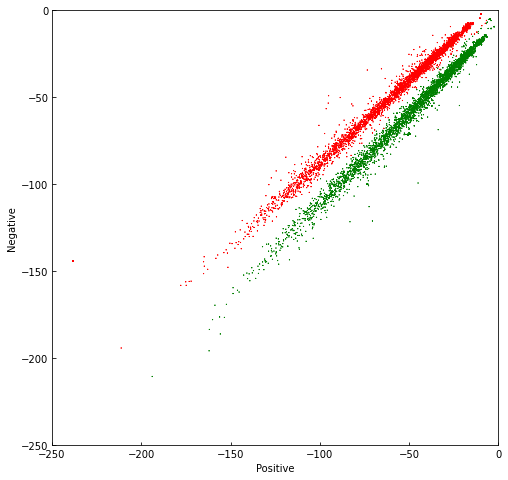

In [48]:
fig,ax=plt.subplots(figsize=(8,8))
colors=['red','green']
ax.tick_params(direction='in')

ax.scatter(data.positive,data.negative,s=0.1,marker='*',
              c=[colors[int(k)] for k in data.sentiment])

plt.xlim(-250,0)
plt.ylim(-250,0)

plt.xlabel("Positive") 
plt.ylabel("Negative") 

# Using Confidence Ellipses to interpret Naïve Bayes

In this section, we will use the [confidence ellipse]( https://matplotlib.org/3.1.1/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py) to give us an idea of what the Naïve Bayes model see.

A confidence ellipse is a way to visualize a 2D random variable. It is a better way than plotting the points over a cartesian plane because, with big datasets, the points can overlap badly and hide the real distribution of the data. Confidence ellipses summarize the information of the dataset with only four parameters: 

* Center: It is the numerical mean of the attributes
* Height and width: Related with the variance of each attribute. The user must specify the desired amount of standard deviations used to plot the ellipse. 
* Angle: Related with the covariance among attributes.

The parameter __n_std__ stands for the number of standard deviations bounded by the ellipse. Remember that for normal random distributions:

* About 68% of the area under the curve falls within 1 standard deviation around the mean.
* About 95% of the area under the curve falls within 2 standard deviations around the mean.
* About 99.7% of the area under the curve falls within 3 standard deviations around the mean.



In the next chart, we will plot the data and its corresponding confidence ellipses using 2 std and 3 std. 

In [50]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)

    return ax.add_patch(ellipse)

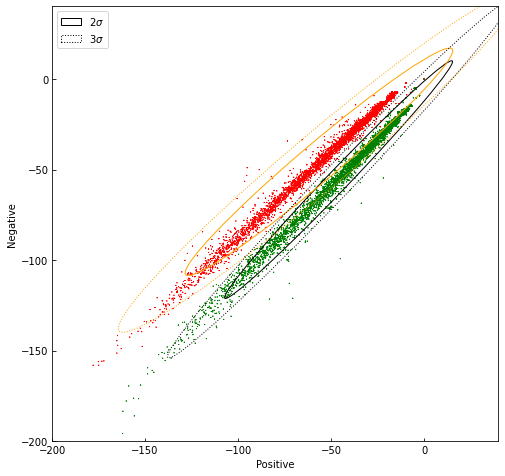

In [51]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

fig,ax=plt.subplots(figsize=(8,8))
colors=['red','green']

ax.tick_params(direction='in')
ax.scatter(data.positive,data.negative,s=0.1,marker='*',
              c=[colors[int(k)] for k in data.sentiment])

plt.xlim(-200,40)  
plt.ylim(-200,40)


plt.xlabel("Positive") 
plt.ylabel("Negative") 

data_pos=data[data.sentiment==1]
data_neg=data[data.sentiment==0]

# Print confidence ellipses of 2 std
confidence_ellipse(data_pos.positive, data_pos.negative, ax, n_std=2, edgecolor='black', label=r'$2\sigma$' )
confidence_ellipse(data_neg.positive, data_neg.negative, ax, n_std=2, edgecolor='orange')

# Print confidence ellipses of 3 std
confidence_ellipse(data_pos.positive, data_pos.negative, ax, n_std=3, edgecolor='black', linestyle=':', label=r'$3\sigma$')
confidence_ellipse(data_neg.positive, data_neg.negative, ax, n_std=3, edgecolor='orange', linestyle=':')
ax.legend()

In the next cell, we will modify the features of the samples with positive sentiment (1), in a way that the two distributions overlap. In this case, the Naïve Bayes method will produce a lower accuracy than with the original data.

In [52]:
data2 = data.copy() 

data2.negative[data.sentiment == 1] =  data2.negative * 1.5 + 50
data2.positive[data.sentiment == 1] =  data2.positive / 1.5 - 50

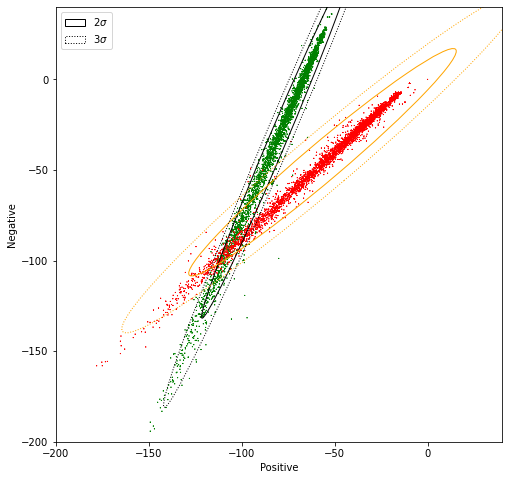

In [53]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red', 'green'] # Define a color palete

# Color base on sentiment

#data.negative[data.sentiment == 1] =  data.negative * 2

ax.scatter(data2.positive, data2.negative, c=[colors[int(k)] for k in data2.sentiment], s = 0.1, marker='*')  # Plot a dot for tweet
# Custom limits for this chart
plt.xlim(-200,40)  
plt.ylim(-200,40)

plt.xlabel("Positive") # x-axis label
plt.ylabel("Negative") # y-axis label

data_pos = data2[data2.sentiment == 1] # Filter only the positive samples
data_neg = data[data2.sentiment == 0] # Filter only the negative samples

# Print confidence ellipses of 2 std
confidence_ellipse(data_pos.positive, data_pos.negative, ax, n_std=2, edgecolor='black', label=r'$2\sigma$' )
confidence_ellipse(data_neg.positive, data_neg.negative, ax, n_std=2, edgecolor='orange')

# Print confidence ellipses of 3 std
confidence_ellipse(data_pos.positive, data_pos.negative, ax, n_std=3, edgecolor='black', linestyle=':', label=r'$3\sigma$')
confidence_ellipse(data_neg.positive, data_neg.negative, ax, n_std=3, edgecolor='orange', linestyle=':')
ax.legend()

plt.show()

To give away: Understanding the data allows us to predict if the method will perform well or not. Alternatively, it will allow us to understand why it worked well or bad.